In [1]:
# Program of baseline DNN model for Original Indoor floor plan (no room baseline).

In [2]:
# Input- Location of Receivers (x,y) and Output- Pathloss (dB)

In [3]:
# Importing library

# Below four lines at top for generalization

from numpy.random import seed
seed(0)
import tensorflow
from tensorflow import keras
tensorflow.random.set_seed(0)

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, r2_score
from sklearn import model_selection

from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA
#To show the output within the jupyter notebook itself!
%matplotlib inline 

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, LeakyReLU, PReLU, ELU, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
# CSV load

df = pd.read_csv("Indoor_floor_plan_org_no_room_baseline.csv")
df.head()

,Unnamed: 0,Rx#,X(m),Y(m),Z(m),Distance (m),Path Loss (dB)
0,0,1.0,0.05,0.05,1.3,10.05510,53.7739
1,1,2.0,0.20,0.05,1.3,10.03460,45.9036
2,2,3.0,0.35,0.05,1.3,10.01620,46.3245
3,3,4.0,0.50,0.05,1.3,10.00010,46.9934
4,4,5.0,0.65,0.05,1.3,9.98624,47.9332


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6678 entries, 0 to 6677
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      6678 non-null   int64  
 1   Rx#             6678 non-null   float64
 2   X(m)            6678 non-null   float64
 3   Y(m)            6678 non-null   float64
 4   Z(m)            6678 non-null   float64
 5   Distance (m)    6678 non-null   float64
 6   Path Loss (dB)  6678 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 365.3 KB


In [6]:
df.describe()

,Unnamed: 0,Rx#,X(m),Y(m),Z(m),Distance (m),Path Loss (dB)
count,6678.000000,6678.000000,6678.000000,6678.000000,6.678000e+03,6678.000000,6678.000000
mean,3338.500000,3339.500000,4.700000,7.925000,1.300000e+00,6.003092,60.704859
std,1927.916881,1927.916881,2.727841,4.590074,2.220612e-16,2.648621,43.365007
min,0.000000,1.000000,0.050000,0.050000,1.300000e+00,0.070710,8.560370
25%,1669.250000,1670.250000,2.300000,3.950000,1.300000e+00,4.030432,44.885525
50%,3338.500000,3339.500000,4.700000,7.925000,1.300000e+00,6.042765,51.442950
75%,5007.750000,5008.750000,7.100000,11.900000,1.300000e+00,7.948900,59.675775
max,6677.000000,6678.000000,9.350000,15.800000,1.300000e+00,12.673800,250.000000


In [7]:
# independent and dependent variables before removing rows having pathloss = 250

X_actual = df[['X(m)','Y(m)']]          # Location of Rxs
y_actual = df[['Path Loss (dB)']]       # Pathloss

In [8]:
X_actual.shape, y_actual.shape

((6678, 2), (6678, 1))

In [9]:
# Removing rows having pathloss = 250 (maximum) in the pathloss column
# note- rows having pathloss of 250 correspond to rows of phi, theta and time as zero.

(df['Path Loss (dB)'] == 250).sum()                            

316

In [10]:
# replacing 250 values with nan. It will drop entire row.

df['Path Loss (dB)'] = np.where(df['Path Loss (dB)'] == 250, np.nan, df['Path Loss (dB)'])

In [11]:
df.isnull().sum() # checking number/shape of null/nan vaues 

Unnamed: 0          0
Rx#                 0
X(m)                0
Y(m)                0
Z(m)                0
Distance (m)        0
Path Loss (dB)    316
dtype: int64

In [12]:
df = df.dropna() # now dropping rows having nan values. It will drop entire rows of dataframe.

In [13]:
df.isnull().sum() # checking shape/size after dropping nan

Unnamed: 0        0
Rx#               0
X(m)              0
Y(m)              0
Z(m)              0
Distance (m)      0
Path Loss (dB)    0
dtype: int64

In [14]:
df.shape  # final dataframe after removing the rows having pathloss = 250 

(6362, 7)

In [15]:
df_final = df # final dataframe after removing the rows having pathloss = 250

In [16]:
df_final.head()

,Unnamed: 0,Rx#,X(m),Y(m),Z(m),Distance (m),Path Loss (dB)
0,0,1.0,0.05,0.05,1.3,10.05510,53.7739
1,1,2.0,0.20,0.05,1.3,10.03460,45.9036
2,2,3.0,0.35,0.05,1.3,10.01620,46.3245
3,3,4.0,0.50,0.05,1.3,10.00010,46.9934
4,4,5.0,0.65,0.05,1.3,9.98624,47.9332


In [17]:
df_final.shape

(6362, 7)

In [18]:
df_final.describe()

,Unnamed: 0,Rx#,X(m),Y(m),Z(m),Distance (m),Path Loss (dB)
count,6362.000000,6362.000000,6362.000000,6362.000000,6.362000e+03,6362.000000,6362.000000
mean,3402.914335,3403.914335,4.549717,8.080753,1.300000e+00,5.895641,51.302585
std,1951.143252,1951.143252,2.700269,4.643685,2.220621e-16,2.660364,10.268534
min,0.000000,1.000000,0.050000,0.050000,1.300000e+00,0.070710,8.560370
25%,1646.250000,1647.250000,2.300000,3.950000,1.300000e+00,3.925317,44.533925
50%,3496.500000,3497.500000,4.550000,8.300000,1.300000e+00,5.856830,50.851600
75%,5086.750000,5087.750000,6.800000,12.050000,1.300000e+00,7.850160,58.358475
max,6677.000000,6678.000000,9.350000,15.800000,1.300000e+00,12.673800,91.733600


#### The distplot represents the univariate distribution of data i.e. data distribution of a variable against the density distribution. It shows the histogram with a line on it.

In [19]:
# function to see distribution

def plot(df_final, feature):
    sns.distplot(df_final[feature])
    plt.show()

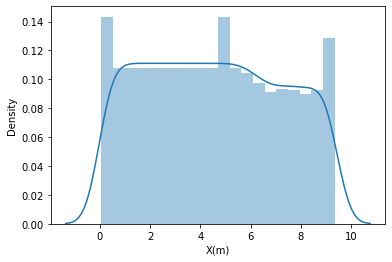

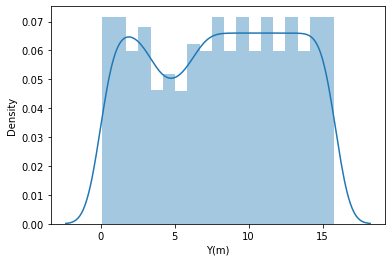

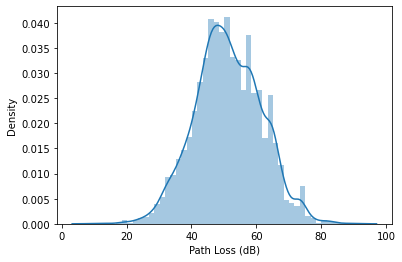

In [20]:
for feature in df_final[['X(m)', 'Y(m)', 'Path Loss (dB)']]:  # seeing distribution of inputs and output
    plot(df_final, feature)

<AxesSubplot:>

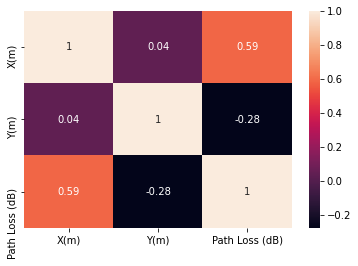

In [21]:
# Seeing correlation heatmap between inputs and outputs # No good correlation here.

columns = df_final[['X(m)', 'Y(m)', 'Path Loss (dB)']]
sns.heatmap(columns.corr(),annot = True)

In [22]:
# Input data i.e. location of Rxs (x,y) 

inputs = df_final[['X(m)','Y(m)']]
inputs.shape

(6362, 2)

In [23]:
inputs.head()

,X(m),Y(m)
0,0.05,0.05
1,0.20,0.05
2,0.35,0.05
3,0.50,0.05
4,0.65,0.05


In [24]:
type(inputs)

pandas.core.frame.DataFrame

In [25]:
# Output data # path loss obtained at each location

output=df_final[['Path Loss (dB)']] 
output.shape

(6362, 1)

In [26]:
output.head()

,Path Loss (dB)
0,53.7739
1,45.9036
2,46.3245
3,46.9934
4,47.9332


In [27]:
type(output)

pandas.core.frame.DataFrame

In [28]:
########################################### PCA starts here ############################################

In [29]:
# No need of PCA here due to two features only #

In [30]:
##################################### PCA over here ####################################################

In [31]:
# Pre-processing

x = inputs.values  # converting dataframe "inputs" into array form
x # location of receivers (X and Y co-ordinates)

array([[ 0.05,  0.05],
       [ 0.2 ,  0.05],
       [ 0.35,  0.05],
       ...,
       [ 9.05, 15.8 ],
       [ 9.2 , 15.8 ],
       [ 9.35, 15.8 ]])

In [32]:
y = output.values # converting dataframe "output" into array form 
y # y is path loss at each location

array([[53.7739],
       [45.9036],
       [46.3245],
       ...,
       [59.6553],
       [63.507 ],
       [57.4723]])

In [33]:
y.shape

(6362, 1)

In [34]:
type(y)

numpy.ndarray

In [35]:
# Splitting data for training and testing 
# Here both x and y are in array form (non-scaled)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0) 

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [36]:
# Feature Scaling # MinMaxScaler # zero mean, unit variance # range [0,1].
# Here scaling input and output both (but separately)

scaler1 = MinMaxScaler()
x_train = scaler1.fit_transform(x_train)
x_test = scaler1.transform(x_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_test = scaler2.transform(y_test)

In [37]:
# x_train.min(), x_test.max()

In [38]:
 # Converting dataframe into array
    
X_actual_arr = X_actual.values  

In [39]:
# Scaling 

X_actual_norm = scaler1.fit_transform(X_actual_arr)

In [40]:
X_actual_norm.shape

(6678, 2)

In [41]:
X_actual_norm.min(), X_actual_norm.max() 

(0.0, 1.0000000000000002)

In [42]:
# Model developed for x=> y mapping i.e, location -> pathloss

In [43]:
# Building neural network

def baseline_model():
    
    # creating model
    model = Sequential()
    model.add(Dense(64, input_dim=x.shape[1], activation='relu', kernel_initializer='random_normal')) # Input layer and 1st hidden layer
    # model.add(BatchNormalization())
#     model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_initializer='random_normal')) # 2nd Hidden layer
    # model.add(BatchNormalization())
#     model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', kernel_initializer='random_normal')) # 3rd Hidden layer 
    model.add(Dense(y.shape[1], activation='relu', kernel_initializer='random_normal')) # Output Layer
    # compiling model
    model.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error', metrics = ['mean_absolute_error']) 
    
    return model

In [44]:
m = baseline_model()

In [45]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Early Stopping

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=2)

# it stops the training after 5 epochs if the validation loss doesn't improve
# Verbosity mode 0 = silent, 1 = progress bar, 2 = one line per epoch.

In [47]:
# Fitting Neural network to training set

history=m.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[early_stopping],
              batch_size=16, epochs=150)

# # verbose 0 = silent, 1 = progress bar, 2 = one line per epoch; verbose=2 is recommended.

Epoch 1/150
279/279 [==============================] - 2s 3ms/step - loss: 0.0474 - mean_absolute_error: 0.1502 - val_loss: 0.0094 - val_mean_absolute_error: 0.0755
Epoch 2/150
279/279 [==============================] - 1s 2ms/step - loss: 0.0097 - mean_absolute_error: 0.0755 - val_loss: 0.0092 - val_mean_absolute_error: 0.0743
Epoch 3/150
279/279 [==============================] - 1s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0748 - val_loss: 0.0095 - val_mean_absolute_error: 0.0737
Epoch 4/150
279/279 [==============================] - 1s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0744 - val_loss: 0.0094 - val_mean_absolute_error: 0.0775
Epoch 5/150
279/279 [==============================] - 1s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0734 - val_loss: 0.0089 - val_mean_absolute_error: 0.0722
Epoch 6/150
279/279 [==============================] - 1s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0731 - val_loss: 0.0088 - val_mean_absolute_error: 0.0733
Epoch 7/15

279/279 [==============================] - 1s 3ms/step - loss: 0.0048 - mean_absolute_error: 0.0518 - val_loss: 0.0049 - val_mean_absolute_error: 0.0514
Epoch 51/150
279/279 [==============================] - 1s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0514 - val_loss: 0.0048 - val_mean_absolute_error: 0.0522
Epoch 00051: early stopping


In [48]:
# Fitting Neural network to training set

# history=m.fit(x_train, y_train, validation_data=(x_test, y_test), 
#               batch_size=16, epochs=500)

# verbose 0 = silent, 1 = progress bar, 2 = one line per epoch; verbose=2 is recommended.

In [49]:
# To save training history of model in csv file

# pd.DataFrame(history.history).to_csv("training_history.csv")

In [50]:
# list all data (metrics) in training history

print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


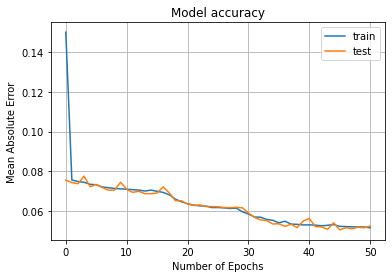

In [51]:
# To summarize history for accuracy
# Plot of accuracy on the training and validation (test) datasets over training epochs

acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']

plt.plot(acc)
plt.plot(val_acc)
plt.grid('True')
plt.title('Model accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'test'], loc='upper right')
# plt.savefig('accuracy.pdf')
plt.show()

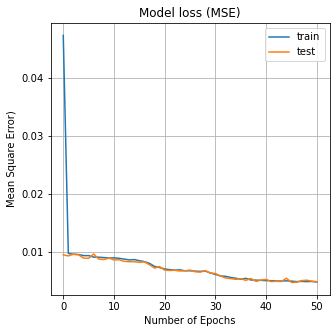

In [52]:
# To summarize history for loss
# Plot of loss on the training and validation (test) datasets over training epochs.

plt.figure(figsize=(5, 5))
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.grid('True')
plt.title('Model loss (MSE)')
plt.ylabel('Mean Square Error)')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'test'], loc='upper right')
# plt.ylim(0.002,0.012)
# plt.savefig('loss.pdf')
plt.show()

In [53]:
# Making the predictions for testing

# Predicting the Test set results
y_pred = m.predict(x_test) 
# y_pred

In [54]:
y_pred.shape

(1909, 1)

In [55]:
# Y actual from the predicted one.

y_pred_all = m.predict(X_actual_norm)

In [56]:
y_pred_all.min(), y_pred_all.max()

(0.1696414, 0.7293147)

In [57]:
# Actual pathloss from the predicted pathloss 

y_pred_all_inv = scaler2.inverse_transform(y_pred_all)
y_pred_all_inv

array([[55.946926],
       [56.023598],
       [56.099575],
       ...,
       [59.04268 ],
       [58.7885  ],
       [58.534336]], dtype=float32)

In [58]:
y_pred_all_inv.min(), y_pred_all_inv.max()

(25.502834, 68.80369)

In [59]:
# Model performance # Test error

# Measure MSE error  
mse_test = metrics.mean_squared_error(y_test, y_pred)
print("Test Mean Squared error (MSE): {}".format(mse_test))

# Measure RMSE error 
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Test Root mean squared error (RMSE): {}".format(rmse_test))

# Measure MAE error
mae_test = metrics.mean_absolute_error(y_test, y_pred)
print("Test Mean absolute error (MAE): {}".format(mae_test))

# Regression score for test 
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()
r2_score_test = metrics.r2_score(y_test_flat, y_pred_flat)
print("R2 Score Test: {}".format(r2_score_test))

Test Mean Squared error (MSE): 0.004787891431108487
Test Root mean squared error (RMSE): 0.0691945910538424
Test Mean absolute error (MAE): 0.05224689137191707
R2 Score Test: 0.7211711477680405


In [60]:
# Making the predictions for training

# Predicting the Training set results
y_pred_train = m.predict(x_train) 
y_pred_train

array([[0.7098434 ],
       [0.5366711 ],
       [0.37403646],
       ...,
       [0.5127033 ],
       [0.6336515 ],
       [0.598426  ]], dtype=float32)

In [61]:
y_pred_train.shape 

(4453, 1)

In [62]:
# Model performance # Training error

# Measure MSE error  
mse_train = metrics.mean_squared_error(y_train, y_pred_train)
print("Training Mean Squared error (MSE): {}".format(mse_train))

# Measure RMSE error 
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
print("Training Root mean squared error (RMSE): {}".format(rmse_train))

# Measure MAE error
mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
print("Training Mean absolute error (MAE): {}".format(mae_train))

# Regression score for training
y_pred_train_flat = y_pred_train.flatten()
y_train_flat = y_train.flatten()
r2_score_train = metrics.r2_score(y_train_flat, y_pred_train_flat)
print("R2 Score Train: {}".format(r2_score_train))

Training Mean Squared error (MSE): 0.0046497917780712805
Training Root mean squared error (RMSE): 0.06818938171058073
Training Mean absolute error (MAE): 0.05150244819696026
R2 Score Train: 0.7388007772349654


In [63]:
####################################### Evaluating Model #######################################

In [64]:
# Cross-validation for training data

estimator = KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=16, verbose=0)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print("CV scores: {}".format(results))
print("Mean CV score (train): %.10f (%.10f)" % (results.mean(), results.std()))

CV scores: [-0.00448171 -0.00417438 -0.00433703]
Mean CV score (train): -0.0043310400 (0.0001255387)


In [65]:
# Cross-validation for test data

estimator = KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=16, verbose=0)
kfold = KFold(n_splits=3)
results = cross_val_score(estimator, x_test, y_test, cv=kfold, scoring='neg_mean_squared_error')
print("CV scores: {}".format(results))
print("Mean CV score (test): %.10f (%.10f)" % (results.mean(), results.std()))

CV scores: [-0.00533663 -0.00493517 -0.27101605]
Mean CV score (test): -0.0937626168 (0.1253372094)


In [66]:
# Saving results in csv file

no_epoch = len(loss)

results = pd.DataFrame([[mse_train, mse_test, mae_train, mae_test, no_epoch]],
columns=['MSE Train', 'MSE Test', 'MAE Train', 'MAE Test', 'No_of_Epochs'])
# results.to_csv('results_baseline_model.csv')

In [67]:
results 

,MSE Train,MSE Test,MAE Train,MAE Test,No_of_Epochs
0,0.00465,0.004788,0.051502,0.052247,51


In [68]:
# Saving baseline model

m.save('no_room_baseline.h5')  

In [69]:
# done